# Module 4: Bivariate analysis - 2 qualitative variables

To demonstrate the concepts in this module, we import dataset `rlanders.csv`. It contains synthetic data that was generated randomly (see [the description](../data/rlanders.md)).

In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic diagram
import seaborn as sns                               # Advanced data visualisation

/tmp/ipykernel_11971/48876594.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd                                 # Data Frame


In [2]:
# Read dataset + data preparation
rlanders = pd.read_csv('https://raw.githubusercontent.com/HoGentTIN/dsai-en-labs/main/data/rlanders.csv').set_index(['ID'])
rlanders.Gender = rlanders.Gender.astype('category')
likert_scale = CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
rlanders.Survey = rlanders.Survey.astype(likert_scale)
# rlanders.info()
# rlanders.Survey.dtype

## Contingency tables and visualisation techniques

Let's say we want to know whether women and men (variable `Gender`) within the sample have responded differently on a survey question with a Likert scale (variable `Survey`). 

If the proportions of the answers (1 to 5) for women and men are about the same, we say that there is no association between the two variables. If there is a significant difference, then there is an association. Now, of course, the question is when is the difference large enough to be considered *significant*...

A first step is to calculate a contingency table. We immediately add the marginal totals:

In [3]:
pd.crosstab(rlanders.Survey, rlanders.Gender, margins=True)

Gender,Female,Male,All
Survey,,,
1,0,4,4
2,17,45,62
3,23,91,114
4,12,53,65
5,0,5,5
All,52,198,250


### Clustered bar chart

Of course, such a table does not say much. Perhaps we should visualise the data.

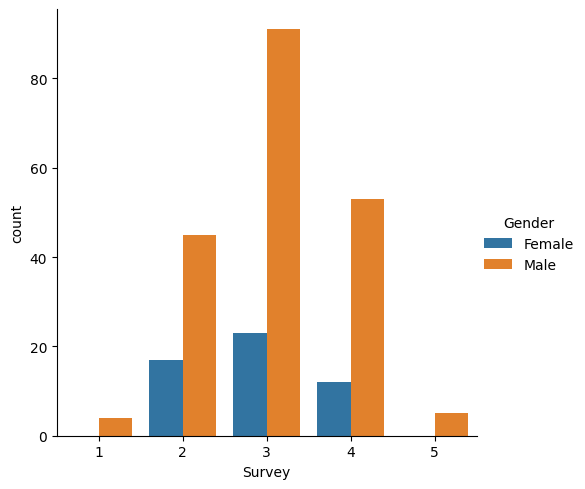

In [20]:
sns.catplot(data=rlanders, x='Survey', hue='Gender', kind='count')
# Door staafdiagram zie je al of er een verband is tussen beide geslachten

If the "shape" of the bars for both categories is similar, we can conclude that both categories have a similar distribution, or that there is no association between the two variables. If the shape were different (e.g. highest peak for men at 2 and for women at 4), that would indicate that there actually is an association, or that men and women give significantly different answers to the survey question.

In this case, what is striking is that the women did not give the extreme answers (1 or 5). However, there are considerably fewer women in the sample, so that may be just a coincidence, not necessarily a significant pattern.

### Stacked bar chart

Another way to visualize the data is by stacking the bars instead of clustering them. Unfortunately, Seaborn doesn't provide us with a convenient method to do so. However, a crosstab object (actually a Pandas DataFrame) has a plot method that we can use. Remark that we swapped the variables when calling the crosstab function.

<Axes: xlabel='Gender'>

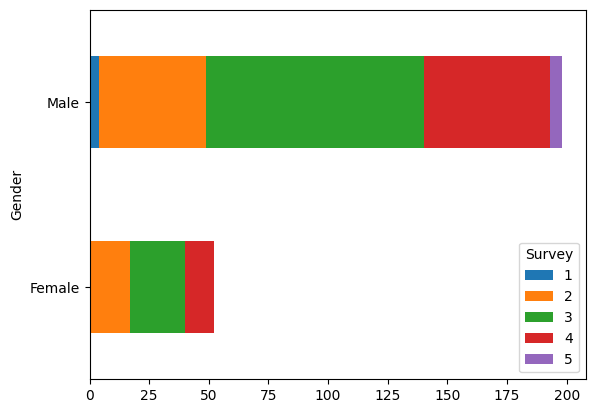

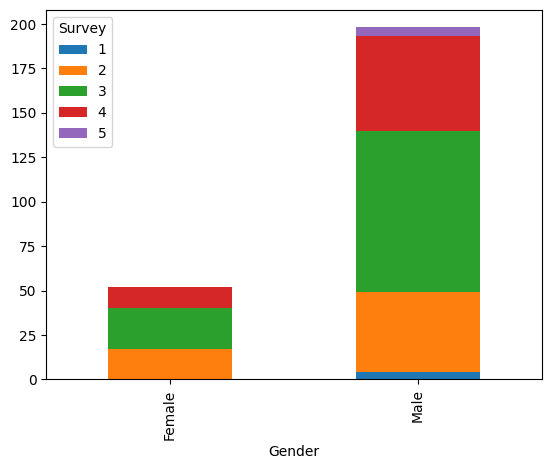

In [4]:
# Contingency table without the margins
observed = pd.crosstab(rlanders.Gender, rlanders.Survey)

# Horizontally oriented stacked bar chart
observed.plot(kind='barh', stacked=True)
# barh = horizontal barchart, als je 'bar' gebruikt, is het een vertical barchart
observed.plot(kind='bar', stacked=True)

We want to compare the proportions within each category (Male, Female) that replied to the survey question. In data sets with large differences in the number of observations for each category, this representation is still difficult to interpret. By looking at the *relative* frequencies (i.e. percentages), we may get a better result:

<AxesSubplot: ylabel='Gender'>

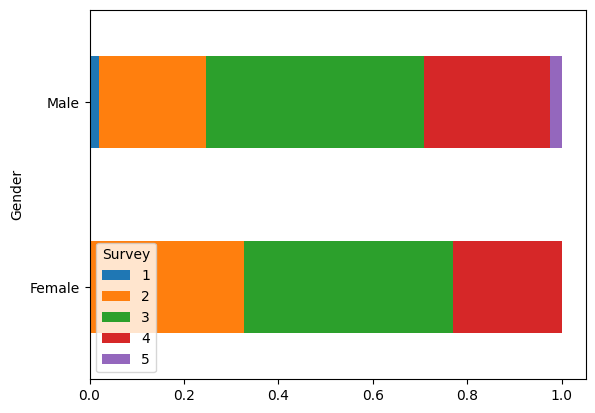

In [24]:
# Contingency table without the margins
observed_p = pd.crosstab(rlanders.Gender, rlanders.Survey, normalize='index')

# Horizontally oriented stacked bar chart
observed_p.plot(kind='barh', stacked=True)

We can see that there are some differences between the proportions, e.g. the percentage of women answering "2" (orange) seems larger than the men. Whether this is a significant difference remains to be seen (see below for further analysis of this case).

In this representation we lose the information about the number of men and women in the sample. Specifically, we don't see that there are much less women. A mosaic diagram solves this problem.

### Mosaic diagram
A mosaic diagram is a graphical representation of the crosstab where each cell is represented by a tile whose area is proportional to the frequency of that cell with respect to the total number of observations.

You can compare this a bit with how [WinDirStat](https://windirstat.net/) visualises the size of files on your hard disk.

For this case:

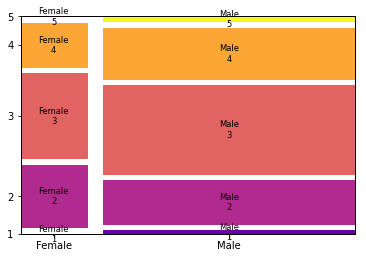

In [4]:
from matplotlib import cm

# By default, mosaic() will color all columns the same. Here,
# we're going to give a separate color to each response (1-5).
# The response is kept in the label of each cell, a tuple of
# the two values that are represented in that cell (e.g. 
# ('Female', '2')). We will be using the "plasma" color map
# in this example.
plasma_colors = cm.get_cmap('plasma')
# Create a function that maps the cell key to the color we
# want to give it. We use the colormap function created above
# and give it a number between 0 and 1. We convert the second
# part of the key (values '1' to '5') to a number and divide
# by 5.
props = lambda key: {'color': plasma_colors(int(key[1])/5)}

mos_gender_survey = mosaic(
       data=rlanders, index=['Gender', 'Survey'],
       gap=0.05, properties=props)

We can clearly see here that there are more men in the sample (wider tiles).

You can also compare the distributions of the answers given to the survey question. Except for the fact that the women did not give extreme answers (1 and 5), at first sight, the distributions still seem to match quite well.

## Chi-squared and Cramér's V

Chi-squared ($\chi^2$) and Cramér's V are statistics that can help us to determine whether there is an association between two qualitative (categorical) variables.

The reasoning goes as follows: if there is no association between `Gender` and `Survey`, then we expect the proportions of the values of `Survey` to be the same for all values of `Gender`. In other words, for both women and men, the same percentage of respondents will give the same answer to the question.

In [8]:
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
# Berekening (som van rijen & some van kolommen)
row_sums = observed.sum(axis=1)
col_sums = observed.sum()
n = row_sums.sum()

print(row_sums)
print(col_sums)
print(f'Number of observations: {n}')

Survey
1      4
2     62
3    114
4     65
5      5
dtype: int64
Gender
Female     52
Male      198
dtype: int64
Number of observations: 250


Now we can calculate how often we can expect each combination of `Gender` and `Survey` to occur in the sample. For example, 114 out of 250 respondents answered "3", i.e. 114/250 = 0.456 (or 46.6%). Then we know that both 46.6% of the women and 46.6% of the men must have answered "3". Since there were 52 female respondents, we expect that 52 x 0.456 = 23.712 have answered "3". In reality, there were 23. For the men, we expect 198 x 0.456 = 90.288 (compared to 91 in reality).

We can generalise this principle to any cell in the table: $\frac{row total \times column total}{n}$ (with $n$ the total number of observations).

The expected values can be calculated using the `outer()` function:

In [10]:
# Theoretisch te verwachten waarden
expected = np.outer(row_sums, col_sums) / n
expected

array([[ 0.832,  3.168],
       [12.896, 49.104],
       [23.712, 90.288],
       [13.52 , 51.48 ],
       [ 1.04 ,  3.96 ]])

Let's check if the marginal totals are still correct:

In [11]:
exp_row_sums = np.sum(expected, axis=1)
exp_col_sums = np.sum(expected, axis=0)

print(f'Row totals   : {exp_row_sums}')
print(f'Column totals: {exp_col_sums}')
print(f'Observations : {exp_col_sums.sum()}')

Row totals   : [  4.  62. 114.  65.   5.]
Column totals: [ 52. 198.]
Observations : 250.0


Indeed, they do. Now, what's the difference between the expected and observed values?

In [12]:
expected - observed

Gender,Female,Male
Survey,,
1,0.832,-0.832
2,-4.104,4.104
3,0.712,-0.712
4,1.520,-1.520
5,1.040,-1.040


Some observed values seem to be close to the expected ones (e.g. for "3"), others are further away (e.g. "2"). However, we must also see the differences in proportion.

A measure for determining the total deviation in a frequency table is to square the differences between expected and observed values (just as one does with variance/standard deviation) and divide by the expected value:

In [13]:
diffs = (expected - observed)**2 / expected
print(diffs)

Gender    Female      Male
Survey                    
1       0.832000  0.218505
2       1.306050  0.343003
3       0.021379  0.005615
4       0.170888  0.044880
5       1.040000  0.273131


The sum of all these values is called $\chi^2$ ("chi-squared"):

$\chi^2 = \sum_i \frac{(o_i - e_i)^2}{e_i}$

with $o_i$ the number of observations in the $i$'th cell of the contingencytable and $e_i$ the expected frequency. Compare the formula with the code above to find similarities!

In [14]:
chi_squared = diffs.values.sum()
print('χ² ≈ %.3f' %chi_squared)

χ² ≈ 4.255


Now, this value in itself still does not say very much. Under what conditions do we say that there is or isn't an association between the two variables? That will also depend on the size of the table and the total number of observations. In a contingency table with more rows/columns, you will need a larger $\chi^2$ before you can conclude that there is an association.

[Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) is a formula that normalises $\chi^2$ to a value between 0 and 1 that is independent of the table size.

$V = \sqrt{\frac{\chi^2}{n(k-1)}}$

In [15]:
dof = min(observed.shape) - 1
cramers_v = np.sqrt(chi_squared / (dof * n))
print(cramers_v)

0.13046762087242633


To draw a conclusion from this figure, compare it with the values in the table below:

| Cramér's V | Interpretation          |
| :---:      | :---                    |
| 0          | No association          |
| 0.1        | Weak association        |
| 0.25       | Moderate association    |
| 0.50       | Strong association      |
| 0.75       | Very strong association |
| 1          | Complete association    |

So our result for Cramér's V indicates a fairly weak association. Note that Cramér's V is known to be too optimistic about the association between two variables in certain cases. There is a modified formula for eliminating this bias, but it is beyond the scope of this course.

There is, however, another way to determine whether the chi-square is large enough to conclude that there is a relationship, namely by means of a statistical test.

## The chi-squared test for independence

To answer the question of when the value of chi-square is sufficient to assume an association between two variables, we can use the *chi-square independence test*.

### The chi-squared distribution

The value of $\chi^2$ follows a specific stochastic distribution that is called the $\chi^2$-distribution. Just like with the Student-t distribution, the shape of the probability density function depends on the degrees of freedom, which in this context is $df = (r-1)\times(k-1)$ (with $r$ the number of rows in the contingency table and $k$ the number of columns).

The code below plots the probability density function of the $\chi^2$-distribution for a number of degrees of freedom:

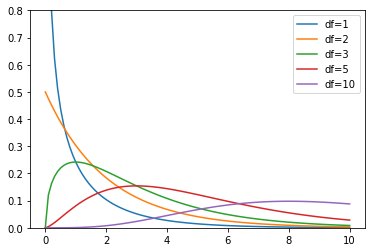

In [12]:
# Plot of the chi-squared distribution for different degrees of freedom
x = np.linspace(0, 10, num=100)
fig, tplot = plt.subplots(1, 1)
tplot.set_ylim([0, 0.8])
tplot.plot(x, stats.chi2.pdf(x, 1), label="df=1") 
tplot.plot(x, stats.chi2.pdf(x, 2), label="df=2") 
tplot.plot(x, stats.chi2.pdf(x, 3), label="df=3")
tplot.plot(x, stats.chi2.pdf(x, 5), label="df=5")
tplot.plot(x, stats.chi2.pdf(x, 10), label="df=10")
tplot.legend(loc='best')

Using this figure, you can follow a reasoning similar to a right-sided z-test. You can calculate a critical value $g$ for which the area under the curve to the right of $g$ is equal to our chosen significance level $\alpha$. If the test statistic $\chi^2$ is greater than $g$, we say that the deviations from the expected values in the contingency table are too large to be coincidental and that we have reason to believe that there is an association between the two variables.

You can also calculate the excess probability $p$, i.e. the probability that the deviations you see in the sample could be due to random sampling errors. To do this, you calculate the area under the density curve to the right of $p$. If this area is smaller than $\alpha$, we also say that the deviations are too large to be caused by random sampling errors and that there is therefore an association between the variables.

In Python, we use the following Scipy functions for this purpose:

- `stats.chi2.sf(x)` - the right tail probability of `x` (or survival function)
- `stats.chi2.isf(q)` - the inverse function of `sf(x)`, i.e. calculate a number `x` for which the right tail probability is exactly `q`.

A plot for the case where $\alpha = 0.05$ (an often chosen value for the significance level) and 4 degrees of freedom:

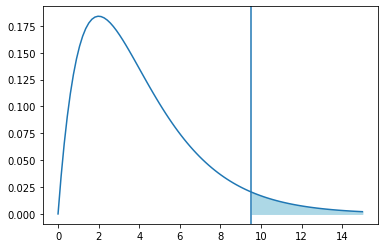

In [16]:
# Right tail probability in the chi-squared distribution

# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=4)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(.05, df=4)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                      # probability density
tplot.fill_between(x, y, where=x>=q,  # critical area
    color='lightblue')
tplot.axvline(q)                      # critical value

### Test procedure

Formally, the procedure of the $\chi^2$ test for independence runs as follows:

1. Formulate the hypotheses:
   - $H_0$: There is no association between the variables (the differences between observed and expected values are small)
   - $H_1$: There is an association between the variables (the differences are large)
2. Choose significance level $\alpha$
3. Calculate the value of the test statistic in the sample (here: $\chi^2$).
4. Use one of the following methods (based on the degrees of freedom $df = (r-1) \times (k-1)$):
   1. Determine critical value $g$ so $P(\chi^2 > g) = \alpha$
   2. Calculate the $p$-value
5. Draw a conclusion based on the outcome:
   1. $\chi^2 < g$: do not reject $H_0$; $\chi^2 > g$: reject $H_0$
   2. $p > \alpha$: do not reject $H_0$; $p < \alpha$: reject $H_0$

In Python, we can calculate this as follows:

In [13]:
alpha = .05
dimensions = observed.shape
dof = (dimensions[0]-1) * (dimensions[1]-1)

print("Chi-squared        : %.4f" % chi_squared)
print("Degrees of freedom : %d" % dof)

# Calculate critical value
g = stats.chi2.isf(alpha, df = dof)
print("Critical value     : %.4f" % g)

# Calculate p-value
p = stats.chi2.sf(chi_squared, df=dof)
print("p-value            : %.4f" % p)

Chi-squared        : 4.2555
Degrees of freedom : 4
Critical value     : 9.4877
p-value            : 0.3725


Actually, we do not need to memorise these formulas to determine chi-square, the critical value and the p-value. SciPy already has a function that allows us to calculate the chi-square and p-value directly from a contingency table:

In [17]:
# Chi-squared test for independence based on a contingency table
# Dit is de korte Python versie!!!! Vervangt al het bovenstaande op een snelle wijze
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
chi2, p, df, expected = stats.chi2_contingency(observed)

print("Chi-squared       : %.4f" % chi2)
print("Degrees of freedom: %d" % df)
print("P-value           : %.4f" % p)

Chi-squared       : 4.2555
Degrees of freedom: 4
P-value           : 0.3725


As you can see, the outcome for the $p$-value is the same as in our worked out calculations!

A graphical representation of our case:

In [18]:
# Is there an association between Gender and Survey?

# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=4)  # TODO: CHECK this!

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

NameError: name 'alpha' is not defined

We see that $\chi^2$ is well within the region of acceptance. The $p$-value is also greater than $\alpha$. Consequently, we cannot reject the null hypothesis and conclude that, based on this sample, there is no reason to believe that there is a significant difference between women's and men's answers to the survey question.

## Goodness-of-fit test

Suppose that in a sample of superheroes we keep track of what type they are and that we also know how often each type occurs in the entire population (as a percentage). Given below are the absolute frequencies in the sample $o_i$ and the expected relative frequencies $\pi_i$ in the population:

In [19]:
types =               ['mutant', 'human', 'alien', 'god', 'demon']
observed =   np.array([   127,      75,      98,     27,     73])
expected_p = np.array([   .35,     .17,     .23,    .08,    .17])

The question now is: is this sample representative of the population? Does each type occur in the sample in proportion to the expected percentage in the population as a whole?

### Test procedure

To answer these kinds of questions, a goodness-of-fit test is suitable. The procedure is as follows:

1. Formulate the hypotheses:
   - $H_0$: The sample is representative of the population, i.e. the frequency of each class within the sample corresponds well to that in the population.
   - $H_1$: The sample is *not* representative of the population, i.e. the differences with the expected frequencies are too large.
2. Choose significance level $\alpha$
3. Calculate the value of the test statistic in the sample (here: $\chi^2$).
4. Use one of the following methods (based on the degrees of freedom $df = (k-1)$ with $k$ the number of categories in the sample):
   1. Determine critical value $g$ so $P(\chi^2 > g) = \alpha$
   2. Calculate the $p$-value
5. Draw a conclusion based on the outcome:
   1. $\chi^2 < g$: do not reject $H_0$; $\chi^2 > g$: reject $H_0$
   2. $p > \alpha$: do not reject $H_0$; $p < \alpha$: reject $H_0$

A plot of this case, including the calculation of $p$ and $g$:

In [21]:
observed =   np.array([   127,      75,      98,     27,     73])
expected_p = np.array([   .35,     .17,     .23,    .08,    .17])
alpha = 0.05               # Significance level
n = sum(observed)          # Sample size
k = len(observed)          # Number of categories
dof = k - 1                # Degrees of freedom
expected = expected_p * n  # Expected absolute frequencies in the sample; Procentuele verwachte waarden * aantal elementen
g = stats.chi2.isf(alpha, df=dof)  # Critical value ; Liggen de verwachte waarden dicht genoeg bij de effectieve waarden

# Goodness-of-fit-test in Python:
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print("Significance level  ⍺ = %.2f" % alpha)
print("Sample size         n = %d" % n)
print("k = %d; df = %d" % (k, dof))
print("Chi-squared        χ² = %.4f" % chi2)
print("Critical value      g = %.4f" % g)
print("p-value             p = %.4f" % p)

Significance level  ⍺ = 0.05
Sample size         n = 400
k = 5; df = 4
Chi-squared        χ² = 3.4679
Critical value      g = 9.4877
p-value             p = 0.4828


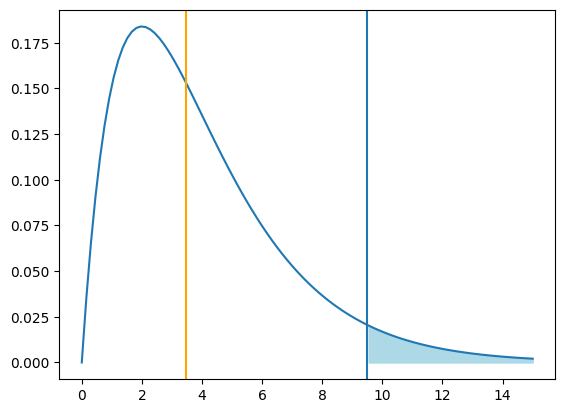

In [22]:
# Plot of the case:
# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=dof)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

We can see that $\chi^2$ in the sample is left of the critical value, so within the area of acceptance. Therefore, we cannot reject the null hypothesis and conclude that the sample is representative for the population, at least w.r.t. the types of superheroes.

## Standardised residuals

After performing a chi-squared test, it is often also interesting to know in which categories the largest deviations occur. You could look at the value $\frac{(o-e)^2}{e}$ for each cell in the contingency table (or vector), which is used in the calculation of $\chi^2$. However, from this you cannot tell to what extent the deviations can really be considered "extreme". For this we use so-called *standardised residuals*.

We introduce this concept by means of an example:

Suppose that a certain study looks at families with 5 children. A sample of 1022 families is taken, and they are divided into categories according to the number of boys in the family. The frequencies are given below in a Pandas DataFrame that we will create manually and systematically extend.

In [19]:
# Data frame with 2 columns:
#  - number of boys in the family (index)
#  - number of families in the sample with that number of boys
families = pd.DataFrame(
    np.array(
        [[0,  58],
         [1, 149],
         [2, 305],
         [3, 303],
         [4, 162],
         [5,  45]]),
    columns=['num_boys', "observed"])
families.set_index(['num_boys'])
n = families.observed.sum() # sample size

Now what is the expected number of families with the given number of boys? Let's assume that the probability of conceiving boys or girls is equally large, i.e. 0.5. In that case, we can calculate the expected relative frequencies with this formula:

$\pi_i = (0.5)^i (1-0.5)^{5-i} \binom{5}{i}$

Why that is the case is not relevant for the subject at hand and is beyond the scope of this course.

The expected absolute frequencies in the sample can then be calculated as $e_i = n \pi_i$.

We apply this to our case:

In [20]:
from scipy.special import binom # binomial-function

# probability for a boy
prob_boy = .5
# Add new colum to the data frame for the expected percentages
families['expected_p'] = binom(5, families.num_boys) * prob_boy**families.num_boys * prob_boy**(5-families.num_boys)
# Expected absolute frequencies in the sample:
families['expected'] = families['expected_p'] * n
families

,num_boys,observed,expected_p,expected
0,0,58,0.03125,31.9375
1,1,149,0.15625,159.6875
2,2,305,0.31250,319.3750
3,3,303,0.31250,319.3750
4,4,162,0.15625,159.6875
5,5,45,0.03125,31.9375


We perform the chi-squared goodness-of-fit test with significance level $\alpha = 0.01$.

In [21]:
alpha=0.01                         # significance level
dof=len(families)-1                # degrees of freedom
g = stats.chi2.isf(alpha, df=dof)  # Critical value
# Perform Chi-squared test, calculate χ² and p
chi2, p = stats.chisquare(f_obs=families.observed, f_exp=families.expected)

print("Chi-squared   χ² = %.4f" % chi2)
print("Critical value g = %.4f" % g)
print("p-value        p = %f"   % p)

Chi-squared   χ² = 28.8462
Critical value g = 15.0863
p-value        p = 0.000025


This is a very small p-value. The chi-squared is also to the right of the critical value. This means that we can reject the null hypothesis. A plot:

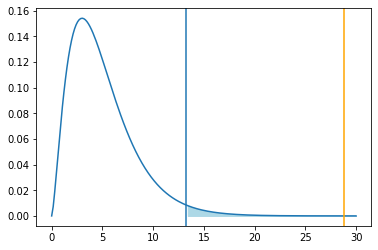

In [22]:
# x-values:
x = np.linspace(0, 30, num=200)
# probability density of the chi-squared distribution
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 1%:
q = stats.chi2.isf(alpha, df=4)  # TODO: CHECK this!

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

We conclude that this sample is NOT representative for the population!

The formula for calculating standardised residuals is:

$r_i = \frac{o_i-e_i}{\sqrt{e_i (1-\pi_i)}}$

We will add these to our data frame in a new column:

In [23]:
families['stdres'] = (families.observed - families.expected) / np.sqrt(families.expected * (1 - families.expected_p))
families

,num_boys,observed,expected_p,expected,stdres
0,0,58,0.03125,31.9375,4.685541
1,1,149,0.15625,159.6875,-0.920733
2,2,305,0.31250,319.3750,-0.970110
3,3,303,0.31250,319.3750,-1.105082
4,4,162,0.15625,159.6875,0.199223
5,5,45,0.03125,31.9375,2.348389


Standardised residuals are a measure of the extent to which a certain category is over- or under-represented in the sample. A value of 0 is given when the observed frequency is equal to the expected frequency. A negative value is given when there are fewer observations than expected and a positive value when there are more. As long as $r_i \in [-2, 2]$, we consider the differences to be random sampling errors. A value $r_i < -2$ indicates underrepresentation of this category, $r_i > 2$ indicates overrepresentation.

Thus, families with only girls and only boys are over-represented in the sample. In practice, researchers could choose to randomly remove a number of observations in these categories from the study, so that the sample becomes representative of the population.

Remark that there is a way to calculate standardized residuals using [`statsmodels.stats.contingency_tables.Table`](https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.Table.html#statsmodels.stats.contingency_tables.Table). However, that only works with [contingency tables for two variables](https://www.statsmodels.org/stable/contingency_tables.html?highlight=residuals), not for this case with one variable.

## Cochran's rule

A chi-squared test can only give good results if you have enough observations in each category. The statistician Cochran (1954) formulated a rule of thumb to determine what exactly *enough* is on contingency tables larger than 2x2:

- All expected values must be at least 1
- At most 20% of the expected values may be smaller than 5

Cochran's rules: om er voor te zorgen dat wanneer een marginale waarde veel afwijkt, dit niet zo maar alles wijzigt.